# This code takes input photoionization models and fits them to the observations of COS-Halos absorption systems

In [1]:
import numpy as np
import scipy.interpolate as interp
#import asciitable
from astropy.io import ascii
import xarray as xr
#import pickle as pk
import pandas as pd

print(xr.__version__,  pd.__version__)


2023.6.0 2.0.3


## Load in model

Define constants and metalicities used
Specifiy which ions to ignore (Low ions)

In [2]:
abundances = {'H':1, 'He':1/12, 'C':2.7e-4, 'N':6.7e-5, 'O':4.9e-4, 'Ne':8.5e-5, 'Mg':4.0e-5, 'Si':3.2e-5, 'S':1.3e-5 }
roman_dict = {'I':0, 'II': 1, 'III':2, 'IV':3, 'V':4, 'VI':5, 'VII':6}  #to map from indexes to array indexes;
            
    
#ignored ions 
dont_use_these_ions = ['O VI', 'H I', 'N I', 'Mg I', 'C I', 'O I', 'Si I', 'Fe I', 'Fe II', 'Fe III', 'N V']

 

RemoveBlends = 1  #removes lines that are specified as blends
min_sigma = 0.1 #minimum standard deviation allowed
max_logHI_column = 17.5  #maximum HI column density allowed
calculate_errors = 1  #calculates errors on parameters
modelstring = 'mix' #'cool' #'lognormal'  #'mix' 'cool'   #'mixcool'
filestring = 'models_frac_eff_Z03'
numbofconstraints = 3  #has to be greater than or equal
epsilon_ionfrac = 1e-10


if modelstring == 'lognormal':
    modeldata  = xr.open_dataset(filestring + '_wss' ,group='gr1')
    model = modeldata.equilibrium #isothermal   equilibrium isobaric adiabatic
    
    modeldata_noss  = xr.open_dataset(filestring +'_noss',group='gr1')
    model_noss = modeldata_noss.equilibrium #isothermal   equilibrium isobaric adiabatic
else:
    modeldata  = xr.open_dataset(filestring+ '_wss',group='gr2') #mixcool
    modeldata_noss  = xr.open_dataset(filestring+ '_noss',group='gr2') #mixcool
    if modelstring == 'mix':
        model = modeldata.mix_lin_fix
        model_noss = modeldata_noss.mix_lin_fix
    elif modelstring == 'cool':
        model = modeldata.cooling_fix
        model_noss = modeldata_noss.cooling_fix
    #print(modeldata.param)
    else:
        print('no such model')



narray = modeldata.n0


# Calculate column for a given ion 

(this is only used in next two blocks and not be fitting code)

In [64]:
#takes in ion name and the total hydrogen column Nnorm
def getModelLogIonicColumn(ion_name, logNnorm, efrac_model):
    ion_name_split = ion_name.split()
    ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()
    return logNnorm + np.log10(abundances[ion_name_split[0]]*(float(efrac_model.sel(ion=ion_name_nospace).values)+ epsilon_ionfrac))

##  examples of how to use model

In [65]:
#specific_model = model.isel(param=2).sel(n0=0.01,method='nearest')
specific_model = model.sel(param=0.8, method='nearest').sel(n0=0.01,method='nearest') 
     #for lognormal, param is the sigma.  For other models it is the fraction in the mixing/cooling gas

#for total hydrogen column of 10^20  print some columns produced by model
print("HI column= ", getModelLogIonicColumn('H I', 20, specific_model), \
      ", CIV column= ",getModelLogIonicColumn('C IV', 20, specific_model))

HI column=  18.746017890599905 , CIV column=  12.863714428608827


# Make plots of some models

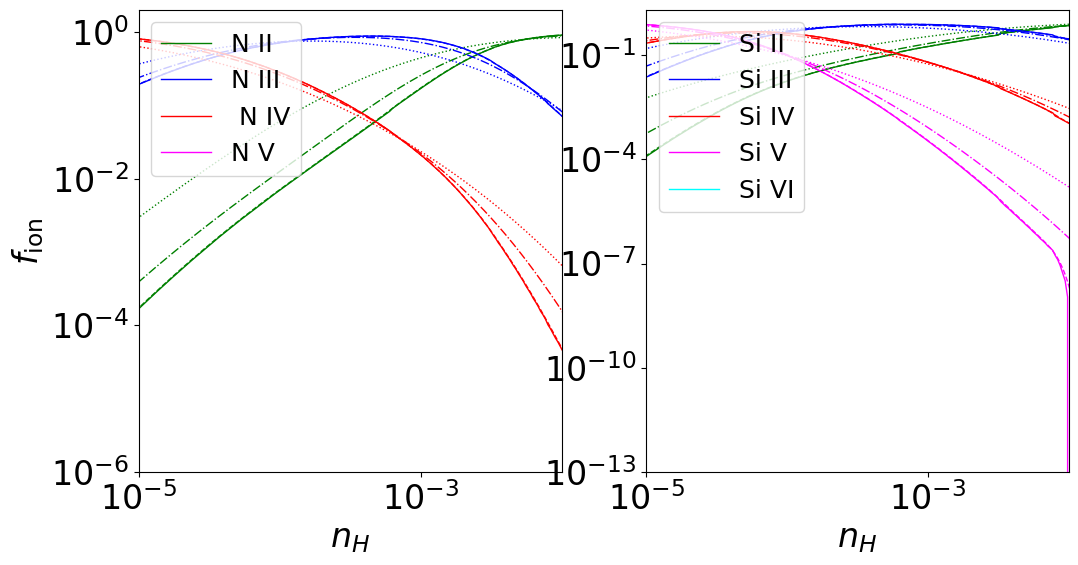

In [6]:
import matplotlib.pyplot as plt
lsarray= ['-', '--', '-.', ':']; colorarray = ['black', 'green', 'blue', 'red', 'magenta', 'cyan', 'brown']
plt.rcParams.update({'font.size': 24})
fig, (p1,p2)=plt.subplots(nrows=1, ncols=2,figsize=(12,6)) #,sharey='all')


##plot carbon
for ion_name in  ['N II', 'N III', ' N IV', 'N V']:
    ion_name_split = ion_name.split()
    ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()
    ionization_val = roman_dict[ion_name_split[1]]
    

    i=0
    for p in modeldata.param.values:
        efrac_model = model.sel(param=p,method='nearest')
        if p == 0:
            legendstring = ion_name
        else:
            legendstring = ''
        p1.loglog(narray, efrac_model.sel(ion=ion_name_nospace).values,  linestyle=lsarray[i], color=colorarray[ionization_val%7],linewidth=1, label=legendstring)
        
        i+= 1
p1.legend(loc='upper left', fontsize=18)
p1.set_xlim([10**-5, .01])
p1.set_ylim([10**-6,2])

##plot silicon
for ion_name in  ['Si II', 'Si III', 'Si IV', 'Si V', 'Si VI']:
    ion_name_split = ion_name.split()
    ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()
    ionization_val = roman_dict[ion_name_split[1]]
    
    
    i=0
    for model_sel in modeldata.param.values:
        efrac_model = model.sel(param=model_sel,method='nearest')
        if model_sel == 0:
            legendstring = ion_name
        else:
            legendstring = ''
        p2.loglog(narray, efrac_model.sel(ion=ion_name_nospace).values,  linestyle=lsarray[i], color=colorarray[ionization_val%7],linewidth=1, label=legendstring)

        i+= 1
    
p2.legend(loc='upper left', fontsize=18)
p2.set_xlim([10**-5, .01])
p2.set_ylim([10**-13,2])


p1.set_xlabel(r"$n_{H}$");p2.set_xlabel(r"$n_{H}$")
p1.set_ylabel(r"$f_{\rm ion}$")
fig.subplots_adjust(wspace=0.2)
p1.legend(loc='upper left', fontsize=18) # bbox_to_anchor=(1.12,.99),markerscale=1.5,framealpha=1,edgecolor='k')
#plt.savefig(f'./Savfig/Isochoric_coolingcolumns.png',bbox_extra_artists=(ionleg,), bbox_inches='tight')


# Read in  Cos-Halos data and output number of systems that meet criteria

In [3]:
metalprof=ascii.read('./Werk_metal_line_profile_fits.dat')
otherabs=ascii.read('./Werk_other_absorber_specs_YakovBlendIdenfication.dat')
HItablelarge = ascii.read('2017-Prochaska-apjaa6007t3_ascii.txt')
divions={}

#file to restructure the input files for our purposes
def systemdict(ID,table):
    #ID is string name of system
    # table is asciitable.read 
    """
           ----    l_logNA    Limit flag on LogNA
          [cm-2]   logNA      Log of adopted ionic column density (4)
          [cm-2]   e_logNA    Uncertainty in logNA
    """

    constraint_count = 0
    limit_count = 0
    housing={}
    for i in range(len(table)):
        if RemoveBlends:
            flag = False if table[i]['Flg'] in [3,11] else True
        else:
            flag = True
        if table[i]['ID'] == ID and flag and isinstance(table[i]['logNA'], float)==True:
            if type(table[i]['e_logNA'])==np.ma.core.MaskedConstant:
                sigma=-1
                limit_count +=1
            else:
                sigma=table[i]['e_logNA']
                if table[i]['Ion'] not in dont_use_these_ions:
                    constraint_count += 1
            housing[table[i]['Ion']]=[table[i]['l_logNA'],table[i]['logNA'],sigma, ID]
            
             
    return [housing, constraint_count, limit_count]


HItable = [[HItablelarge[:][i][0].split()[0], HItablelarge[:][i][0].split()[4]] for i in range(30)]
HItable  = (np.array(HItable)).reshape((30,2))

numberofsystems = 0 #counter
allwerksystems = []
constraint_array = []
ids_noduplicates = [i for n, i in enumerate(metalprof[:]['ID']) if i not in metalprof[:n]['ID']] 
logHI_column = 0
corrected = 0  #when this block is run, corrections then need to be applied (but not twice)

for i in range(len(ids_noduplicates)):
    #print(ids_noduplicates)
    housing, constraint_count, limit_count = systemdict(ids_noduplicates[i],otherabs)
    #print(ids_noduplicates[i], " # constraints = ", constraint_count)
    #galstring == HItable[:][jj][0].split()[0]
    
    # only if in prochaska do we use
    if ids_noduplicates[i] in HItable[:, 0]:
        index = np.where(ids_noduplicates[i] == HItable[:, 0])[0]
        logHI_column = float(HItable[index, 1][0])
        #print("Yes, contains", ids_noduplicates[i], logHI_column )
    #else:
    #print("No it doesn't contain", ids_noduplicates[i])
     # protab[:][jj][2].split()[0] 
    
    if constraint_count >= numbofconstraints and logHI_column < max_logHI_column:
        print(ids_noduplicates[i], " log NHI = ", logHI_column)
        allwerksystems.append(housing)
        numberofsystems +=1 
        constraint_array.append([constraint_count, limit_count])
    #if ids_noduplicates[i] == 'J1435+3604_68_12':
    #    print(housing, constraint_count)

print("number of systems with >= ", numbofconstraints, " constraints is ", numberofsystems)

J0910+1014_242_34  log NHI =  16.63
J1016+4706_274_6  log NHI =  17.11
J1233+4758_94_38  log NHI =  16.78
J1241+5721_208_27  log NHI =  15.35
J1322+4645_349_11  log NHI =  17.17
J1330+2813_289_28  log NHI =  17.14
J1550+4001_197_23  log NHI =  16.52
J1555+3628_88_11  log NHI =  17.36
J2345-0059_356_12  log NHI =  17.36
number of systems with >=  3  constraints is  9


# Make corrections to the systems based on our analysis of what systems look like

In [4]:
#only makes the correction once by setting the "correction" flag.  
##########################################################################
#If you change this code, rerun previous block to read in data first
##########################################################################
if corrected == 0:
    ss_flag = {}
    for Nsyst in allwerksystems:
        print(Nsyst['H I'][-1] )
        ss_flag[Nsyst['H I'][-1]] = False
        if  Nsyst['H I'][-1] == 'J0910+1014_242_34':
            print(Nsyst['H I'][-1], " CIII before = ", Nsyst['C III'][1]),
            Nsyst['C III'][1] =  13.89 #np.log10(10**Nsyst['C III'][1]- 10**13.49 - 10**13.34)
            #Nsyst['C III'][0] =  ''; Nsyst['C III'][2] = 0.9
            
            print(Nsyst['H I'][-1], "CIII after = ", Nsyst['C III'][1])
            print(Nsyst['C II'][0])
        #if  Nsyst['H I'][-1] == 'J1016+4706_274_6':
            #print(Nsyst['H I'][-1], "waiting for resolution of adding issue before I subtract"),
            #Nsyst['Si II'][1] =  np.log10(10**Nsyst['Si II'][1]- 10**12.63)
            #Nsyst['Si III'][1] =  np.log10(10**Nsyst['Si III'][1]- 10**12.74)
            #print(Nsyst['H I'][-1], " Si II after = ", Nsyst['Si II'][1], " Si III after = ", Nsyst['Si III'][1])
        #if  Nsyst['H I'][-1] = 'J1233+4758_94_38':   
        #if Nsyst['H I'][-1] == 'J1241+5721_208_27':
        #    ss_flag[Nsyst['H I'][-1]] = False
        if  Nsyst['H I'][-1] == 'J1322+4645_349_11':
            print(Nsyst['H I'][-1], " Si II before = ", Nsyst['Si II'][1], " Si III before = ", Nsyst['Si III'][1]),
            Nsyst['Si II'][1] =  13.37; #Nsyst['Si II'][2] = 0.15 #np.log10(10**Nsyst['Si II'][1]- 10**12.63)
            Nsyst['Si III'][1] = 13.73 #  np.log10(10**Nsyst['Si III'][1]- 10**12.74)
            Nsyst['Si III'][0] =  ''; Nsyst['Si III'][2] = 0.2
            
            print(Nsyst['H I'][-1], " Si II after = ", Nsyst['Si II'][1], " Si III after = ", Nsyst['Si III'][1])
            ss_flag[Nsyst['H I'][-1]] = True
        if  Nsyst['H I'][-1] == 'J1550+4001_197_23':
            print(Nsyst['H I'][-1], " Mg II before = ", Nsyst['Mg II'][1], " C II before = ", Nsyst['C II'][1], " C III before = ", Nsyst['C III'][1]),
            Nsyst['Mg II'][1] =  12.63 
            Nsyst['C II'][1] =  13.98 #np.log10(10**Nsyst['C II'][1]- 10**13.51)
            #Nsyst['C III'][1] =  14.91 #np.log10(10**Nsyst['C III'][1]- 10**12.88)
            #Nsyst['C III'][0] =  ''; Nsyst['C III'][2]=0.9
            
            print(Nsyst['H I'][-1], " Mg II after = ", Nsyst['Mg II'][1], " C II after = ", Nsyst['C II'][1], "C III after = ", Nsyst['C III'][1])
        if  Nsyst['H I'][-1] == 'J1555+3628_88_11':
            ss_flag[Nsyst['H I'][-1]] = True
        #if Nsyst['H I'][-1] == 'J2345-0059_356_12':
        #    ss_flag[Nsyst['H I'][-1]] = False

    corrected = 1
    #N_observed_dict_[ion][1]
print(ss_flag)

J0910+1014_242_34
J0910+1014_242_34  CIII before =  13.84
J0910+1014_242_34 CIII after =  13.89
--
J1016+4706_274_6
J1233+4758_94_38
J1241+5721_208_27
J1322+4645_349_11
J1322+4645_349_11  Si II before =  13.41  Si III before =  13.65
J1322+4645_349_11  Si II after =  13.37  Si III after =  13.73
J1330+2813_289_28
J1550+4001_197_23
J1550+4001_197_23  Mg II before =  12.71  C II before =  14.05  C III before =  14.1
J1550+4001_197_23  Mg II after =  12.63  C II after =  13.98 C III after =  14.1
J1555+3628_88_11
J2345-0059_356_12
{'J0910+1014_242_34': False, 'J1016+4706_274_6': False, 'J1233+4758_94_38': False, 'J1241+5721_208_27': False, 'J1322+4645_349_11': True, 'J1330+2813_289_28': False, 'J1550+4001_197_23': False, 'J1555+3628_88_11': True, 'J2345-0059_356_12': False}


# Routines for fitting the COS-Halos data and returning best fit and chi^2 values

In [5]:
#given a model for logNmodel, compares against data to calculate chi^2
def chi2_contr(ion_name, logNmodel,logNobs,sigma,l_logNA, large_value=1e5):
    #print(ion_name, ": ", logNobs,sigma,l_logNA)

    if l_logNA == '>': #observations  are upper limit
        sigvec = np.copy(logNmodel)
        epsilon = np.copy(logNmodel)
        #print(np.shape(logNobs), logNmodel)
        sigvec[logNmodel > logNobs]= large_value # model fits observations, so small contribution to chi^2
        sigvec[logNmodel < logNobs]=(min_sigma)
        epsilon[logNmodel < logNobs] = -2*min_sigma #assumes quoted limit is 2 sigma
        

    elif l_logNA == '<': #observations  are lower limit
        sigvec = np.copy(logNmodel)
        epsilon = np.copy(logNmodel)
        sigvec[logNmodel < logNobs]= large_value # model fits observations, so small contribution to chi^2
        sigvec[logNmodel > logNobs]=(min_sigma)
        epsilon[logNmodel > logNobs] = 2*min_sigma  #assumes  quoted limit is 2 sigma

    else:  #observations  are constrained
        sigvec= np.max([min_sigma, sigma]) #sets error bar to be maximum
        epsilon = 0 #*sigvec 

    chi2_contr_eqn=((logNmodel + epsilon)-logNobs)**2 /( sigvec**2 )  
         #for the bounds, epsilon gives 2 sigma error when logNmodel=logNobs

    if np.isinf( chi2_contr_eqn[0]):
        print("chisq = ", chi2_contr_eqn, ion_name, logNmodel,logNobs,sigma,l_logNA)
    return chi2_contr_eqn


#takes observed columns and returns contribution to chi^2
def chi_squared_vector(N_observed_dict_, efrac_model, nHrange, logNnorm): 
    ### chi2_contr is to calculate individual chi2 of an ion 
    
    nHlen  =  sum(nHrange.values)

    
    #model_ions=list(efffrac_dict_.keys())        #create list of ions in model
    observed_ions=list(N_observed_dict_.keys())  #create list of ions in observations
    
    #print("observed_ions = ", observed_ions)
    
    comp_ions=[]
    for ion in observed_ions:
        #if ion in model_ions:
        comp_ions.append(ion)  #this ensures we are only looking at the ions that are present in our and Werk's model

    
    
    chisq_vec = np.zeros(nHlen)
    Nions_fit = 0;  Nions_notlimits = 0
    ion_name_list = []
    
    #loops through ions
    for ion in comp_ions:
        #print("ion =", ion)
        if ion in dont_use_these_ions:  #skip
            continue
        
        #convert to name that has not spaces for dictionary
        ion_name_split = ion.split()
        ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()  
        #this is the calculation of the columns (doesn't use function below)
        logNHmodelarray =  logNnorm + np.log10(abundances[ion_name_split[0]]) \
            + np.log10(efrac_model.sel(ion=ion_name_nospace).values[nHrange]+epsilon_ionfrac)        
        
            
        #these are the observed columns, error, and error flag    
        logNobs=N_observed_dict_[ion][1]
        sigma=N_observed_dict_[ion][2]
        l_logNA=N_observed_dict_[ion][0]
        

        chisq_vec += chi2_contr(ion_name_nospace, logNHmodelarray,logNobs,sigma,l_logNA)
        
        #print("chisq_vec_min = ",  np.min(chisq_vec))
        
        Nions_fit +=1
        if l_logNA != '<' and l_logNA != '>':
            Nions_notlimits += 1 
            
        #break
        ion_name_list.append(ion)
        
    return [chisq_vec, Nions_fit, Nions_notlimits, ion_name_list]

#scans over total columns in search of best fit (density is vectorized)
def findSmallestChisq(Nsyst, efrac_model, nHrange, p):
    min_chisq = 1e10 #start with a high value
    
    #loop over total column values (metalicity is in the total column parameter)
    #THIS IS SUPER STUPID, SHOULD BE ABLE TO RETURN BEST FIT AMPLITUDE
    #could really do this by evaluating at two points if my chi^2 was not discontinous at upper/lower limits
    for logNtot in np.linspace(16, 22, 300):
        [chisq_vec, Nions_fit, Nions_notlimits, ion_name_list] =chi_squared_vector(Nsyst, efrac_model, nHrange, logNtot)
        newestmin = np.min(chisq_vec)

        if newestmin < min_chisq: #save best fit
            min_chisq = newestmin
            logNbest = logNtot
            ibest = np.argmin(chisq_vec)
            #print("lengths = ", len(chisq_vec), len(nHrange), nHrange)
            nHbest = (narray[nHrange == True])[ibest]

    return [min_chisq, logNbest, ibest, nHbest, ion_name_list, p]


#finds the best fit logN at each density (for trouble shooting) -- I started to put this in on 1/19/24
def findSmallestChisqEachDensity(Nsyst, efrac_model, nHrange):
    min_chisq = 1e10
    
    logNtotbestvec = np.zeros(np.count_nonzero(nHrange))
    minchisqvec = np.zeros(np.count_nonzero(nHrange))+min_chisq
    #print("size of array is ", np.shape(nHrange == True), np.shape(nHrange), np.shape(logNtotbestvec))
    #loop over total column values to find best fit at each density
    for logNtot in np.linspace(16, 22, 300):
        [chisq_vec, Nions_fit, Nions_notlimits, ion_name_list] =chi_squared_vector(Nsyst, efrac_model, nHrange, logNtot)
     
        logNtotbestvec[chisq_vec < minchisqvec] = logNtot
        minchisqvec[chisq_vec < minchisqvec] = chisq_vec[chisq_vec < minchisqvec]
        #print(logNtotbestvec)

    return [logNtotbestvec, minchisqvec]


#Calculates the errors (currently on dN only)
dchisq = 2.3 #difference in chi^2 for 2D data that has 68.3% interior (assuming a Gaussian)
def findParameterErrors(Nsyst, efrac_model, nHrange, X):
    #loop over total column values
    [min_chisq, logNbest, ibest, nHbest, ion_name_list, pdummy] = X
    
    dN = -1
    for logNtot in np.linspace(logNbest, logNbest+1, 100):
        [chisq_vec, Nions_fit, Nions_notlimits, ion_name_list] =chi_squared_vector(Nsyst, efrac_model, nHrange, logNtot)
        if np.min(chisq_vec) < min_chisq + dchisq:
            #print("dN = ", logNtot, logNbest, np.min(chisq_vec),  min_chisq)
            dN = logNtot - logNbest #error on column
            
    dn = 0; #error on density (currently does not find)
    
    return [dN, dn]


#major fitting code
def fitSystems(nrange, allwerksystems, model,  modeldata):

    logNbest = None
    all_systems = []
    for Nsyst in allwerksystems:
        systemvaluesparameters = []
        bestfitvalues = []
        for p in modeldata.param.values:    

            efrac_model  = model.sel(param=p, method ='nearest')  #.sel(n0=0.01,method='nearest')
            nHvec =modeldata.n0[nrange].values
            nHlength  =  sum(nrange.values)


            #min_chisq, logNbest, ibest, nHbest, ion_name_list = findSmallestChisq(Nsyst, efrac_model, nrange)    
            bestfitparams = findSmallestChisq(Nsyst, efrac_model, nrange, p)    
            min_chisq, logNbest, ibest, nHbest, ion_name_list, pdummy = bestfitparams

            print(p, "minchisq =", min_chisq, nHbest, logNbest, pdummy)

            if calculate_errors:
                [dN, dn] = findParameterErrors(Nsyst, efrac_model, nrange, bestfitparams)


            print("errors =", dN, dn)


            ion_names = []
            logNmodel_values = []
            logNobs_values = []
            sigma_values = []
            limit_values = []

            for ion in ion_name_list:
                # Convert to name that has no spaces for dictionary
                ion_name_split = ion.split()
                ion_name_nospace = ion_name_split[0].strip() + ion_name_split[1].strip()

                # Get observed ion info
                logNobs = Nsyst[ion][1]
                if Nsyst[ion][2] > 0:
                    sigma = max(min_sigma, Nsyst[ion][2])
                else:
                    sigma =  Nsyst[ion][2]
                l_logNA = Nsyst[ion][0]

                efrac_vec = np.array(efrac_model.sel(ion=ion_name_nospace).values)[nrange]
                logNmodel = logNbest + np.log10(abundances[ion_name_split[0]]) + np.log10(efrac_vec[ibest]+epsilon_ionfrac)

                # Append values to the arrays
                ion_names.append(ion)
                logNmodel_values.append(logNmodel)
                logNobs_values.append(logNobs)
                sigma_values.append(sigma)
                limit_values.append(l_logNA)

                print(ion, "model vs observed = ", logNmodel, logNobs, sigma, l_logNA)

            systemvaluesparameters.append([ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values])
            bestfitvalues.append(bestfitparams)
            
            #print("best fit params = ", bestfitparams)

        all_systems.append([bestfitvalues, systemvaluesparameters])
        
    return all_systems

    

# This generates the fits (takes some time)

In [ ]:
nrange = np.logical_and(narray> 1e-5, narray< 1e-1)

#self sheilding fits
all_systems = fitSystems(nrange, allwerksystems, model, modeldata)

#fits that aren't self shielding
all_systems_noss = fitSystems(nrange,  allwerksystems, model_noss, modeldata_noss)    

0.0 minchisq = 15.78519511762757 <xarray.DataArray 'n0' ()>
array(0.00316228)
Coordinates:
    n0       float64 0.003162 18.16722408026756 0.0
errors = 0.18181818181818343 0
C II model vs observed =  14.164500598443823 14.08 0.13 --
C III model vs observed =  14.397200494718241 13.89 -1 >
N II model vs observed =  13.76439897981412 14.17 0.12 --
Mg II model vs observed =  13.207179974909094 13.01 0.1 --
Si II model vs observed =  13.249137802011637 13.22 0.13 --
Si IV model vs observed =  11.76195523232039 12.98 -1 <
S II model vs observed =  12.784698840348128 14.82 -1 <
0.1 minchisq = 15.272965127296176 <xarray.DataArray 'n0' ()>
array(0.00316228)
Coordinates:
    n0       float64 0.003162 18.187290969899664 0.1
errors = 0.17171717171717304 0
C II model vs observed =  14.182465235151358 14.08 0.13 --
C III model vs observed =  14.461249172780049 13.89 -1 >
N II model vs observed =  13.775388378536103 14.17 0.12 --
Mg II model vs observed =  13.205904050474345 13.01 0.1 --
Si II model

0.1 minchisq = 113.2868649703053 <xarray.DataArray 'n0' ()>
array(0.00034284)
Coordinates:
    n0       float64 0.0003428 17.94648829431438 0.1
errors = 0.08080808080807955 0
C II model vs observed =  13.092452897044039 13.43 -1 <
N II model vs observed =  12.308366257405934 13.58 -1 <
N III model vs observed =  13.723674826034182 13.51 -1 <
Mg II model vs observed =  12.094180719624859 12.32 -1 <
Si II model vs observed =  12.229064779735781 12.84 0.1 --
Si III model vs observed =  13.327884565002288 12.72 0.1 --
Si IV model vs observed =  12.765256061009133 13.28 0.11 --
S II model vs observed =  11.627489449463727 14.26 -1 <
0.3 minchisq = 114.49467077870203 <xarray.DataArray 'n0' ()>
array(0.00035697)
Coordinates:
    n0       float64 0.000357 17.926421404682273 0.3
errors = 0.06060606060606233 0
C II model vs observed =  13.119584839940469 13.43 -1 <
N II model vs observed =  12.336465856239986 13.58 -1 <
N III model vs observed =  13.740063218973853 13.51 -1 <
Mg II model vs obse

0.1 minchisq = 17.03627067950824 <xarray.DataArray 'n0' ()>
array(0.00073862)
Coordinates:
    n0       float64 0.0007386 18.207357859531772 0.1
errors = 0.11111111111111072 0
C II model vs observed =  13.701964886602598 13.98 0.12 --
C III model vs observed =  14.602466697636919 14.1 -1 >
N II model vs observed =  13.057389933013575 13.61 -1 <
N III model vs observed =  13.996117068247539 14.25 0.11 --
Mg II model vs observed =  12.701862008602387 12.63 0.1 --
Si II model vs observed =  12.806613012603718 12.81 -1 <
Si III model vs observed =  13.631341427161155 13.39 0.1 --
S II model vs observed =  12.274636944106188 14.64 -1 <
S III model vs observed =  13.270594836740614 14.16 -1 <
0.3 minchisq = 16.33107559997725 <xarray.DataArray 'n0' ()>
array(0.00080077)
Coordinates:
    n0       float64 0.0008008 18.16722408026756 0.3
errors = 0.08080808080807955 0
C II model vs observed =  13.719334455063464 13.98 0.12 --
C III model vs observed =  14.598408883891263 14.1 -1 >
N II model vs 

# Makes the plots

chisq =  [8.328939778594975, 8.54043703823743, 9.619297028859565, 11.510874625298861]
chisq =  [16.479470662501924, 16.6738050792078, 14.535585799024524, 8.44073414998195]
chisq =  [7.097649328540051, 7.679358311383244, 6.590428355671553, 5.774602199220512]
chisq =  [85.03483859014754, 86.4630348433875, 75.56102561796827, 66.49170896261376]
chisq =  [7.353310694469691, 7.366447250631883, 7.627750962216797, 8.002819357939783]
chisq =  [59.13341286488772, 59.93064323062931, 53.189221178939114, 39.50683083317681]
chisq =  [13.05597010370058, 13.445906819667135, 12.130218016952595, 9.145475986631993]
chisq =  [46.10496199331977, 46.02377987949798, 35.964263439927464, 24.80361430079714]
chisq =  [3.5445960179569624, 3.3947044920125378, 3.6241594487442974, 5.174066072127314]


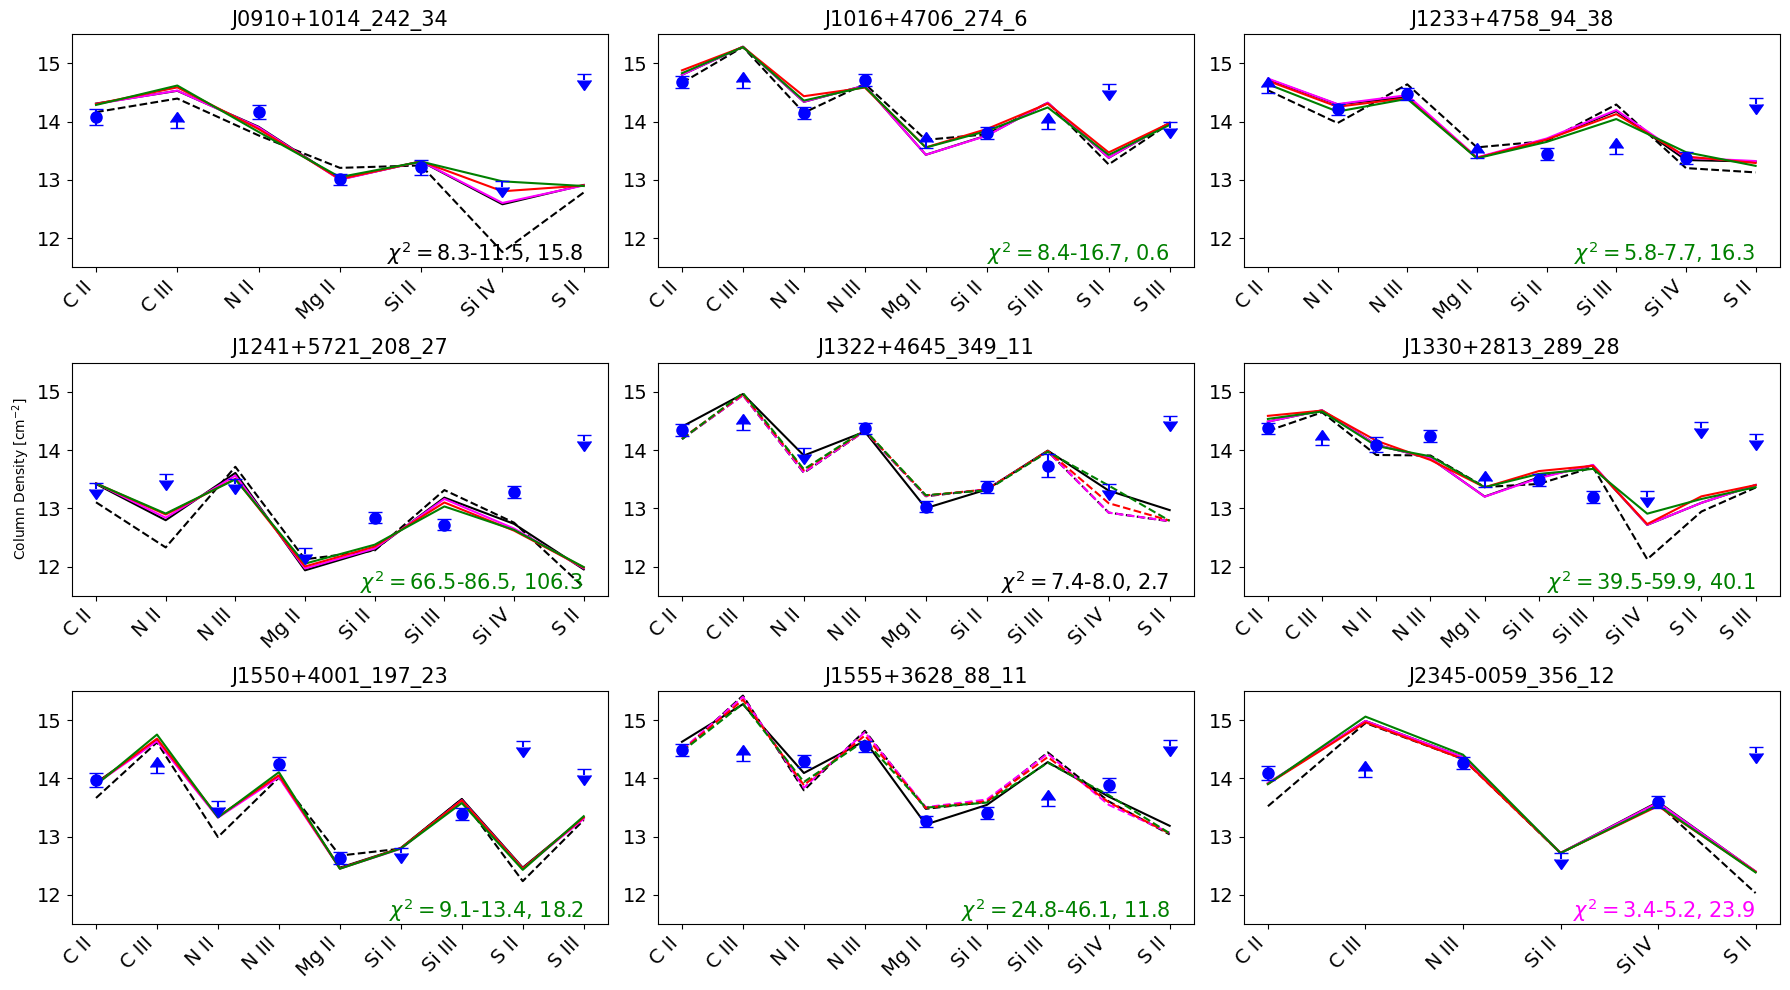

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import re


color_array = ['black', 'magenta', 'red',  'green', 'blue']

# Function to extract the Roman numeral from ion names
def extract_roman_numeral(ion_name):
    match = re.search(r'\b[IVXLCDM]+\b', ion_name)
    if match:
        return match.group()
    return ""

fig, ax = plt.subplots(nrows=len(all_systems)//3, ncols=3, figsize=(18, 10))

for isys in range(len(all_systems)):
    ix = isys//3
    iy = isys%3
    
    if ss_flag[allwerksystems[isys]['H I'][-1]] == False:
        all_systems_plot = all_systems_noss
        all_systems_other = all_systems
        default_linestyle = '-'
        other_linestyle = '--'
    else:
        all_systems_plot = all_systems
        all_systems_other = all_systems_noss
        default_linestyle = '--'
        other_linestyle = '-'
        
    # Sort data by Roman numeral
    [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_plot[isys][1][0]

    ip =0
    chisq_arr = []
    for p in modeldata.param.values: 
        if ip!=0:
            [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_plot[isys][1][ip]
            #sorted_data = sorted(zip(ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values), key=lambda x: extract_roman_numeral(x[0]))

        ax[ix, iy].plot(np.arange(len(ion_names)), logNmodel_values, linestyle=default_linestyle,\
                color=color_array[ip], label=rf'$\sigma={p}$')
        
        if ip == 0:
            [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_other[isys][1][ip]

            ax[ix, iy].plot(np.arange(len(ion_names)), logNmodel_values, linestyle=other_linestyle,\
                color=color_array[ip], label=rf'$\sigma={p}$')
            chisq_other = all_systems_other[isys][0][ip][0]

            
        chisq_arr.append(all_systems_plot[isys][0][ip][0])
        #print(ip, "chisq = ", all_systems_plot[isys][0][ip][0], p)
        
        ip += 1
        
        

    for i, ion in enumerate(ion_names):
        x = i
        y = logNobs_values[i]
        sigma = sigma_values[i]
        if sigma < 0:
            if limit_values[i] == '>':
                ax[ix, iy].errorbar(x, y, yerr=min_sigma, marker='o', markersize=0, color='blue', capsize=5, lolims=True)
            if limit_values[i] == '<':
                ax[ix, iy].errorbar(x, y, yerr=min_sigma, marker='o', markersize=0, color='blue', capsize=5, uplims=True)
        else:
            ax[ix, iy].errorbar(x, y, yerr=sigma, marker='o', markersize=8, color='blue', capsize=5, label=f'{ion} Observed')

        

    print("chisq = ", chisq_arr)
    
    # Set x-axis labels and tick positions
    ax[ix, iy].set_ylim(11.5, 15.5)
    ax[ix, iy].set_xticks(np.arange(len(ion_names)))
    ax[ix, iy].set_xticklabels(ion_names, rotation=45, ha='right')
    ax[ix, iy].tick_params(axis='both', labelsize=14)  
    
    system_name = allwerksystems[isys]['H I'][-1] #.replace('_', '\_')
    ax[ix,iy].set_title(system_name, fontsize=15)
    
    min_index = np.argmin(chisq_arr); max_index = np.argmax(chisq_arr)

    
    ax[ix, iy].text(len(ion_names)-1, 11.5, rf'$\chi^2= ${min(chisq_arr):.1f}-{max(chisq_arr):.1f}, {chisq_other:.1f}', \
                    ha='right', va='bottom', fontsize=15, color=color_array[min_index])


    #ax.legend()
ax[1, 0].set_ylabel('Column Density [cm$^{-2}$]')
# Show the plot
plt.tight_layout()
#plt.show()

plt.savefig(f'systemfits_{modelstring}.pdf')

# Generates table with fitted values

In [89]:
latex_output = 1 #output in latex


def SciNotation(num):
    #print("n0 = ", num)
    x='%.1e'  %num  #<-- Instead of 2, input sig here
    x= x.split('e')
    if (x[1])[0] == "-":
        return "$" +x[0]+r" \times 10^{-"+ x[1][-1] +"}$"
    else:
        return "$" + x[0]+r" \times x 10^{"+ (x[1])[-1] +"}$"

#Nsyst=allwerksystems[0] #Werkdict['_27']['_dict']

if latex_output == 0:
    print("#system constraints limits best_fit_density(sigma=0) best_fit_density(sigma=0.8) best_fit_lgNZ(sigma=0) best_fit_lgNZ(sigma=0.8) chi^2_1 chi^2_2 chi^2_3 chi^2_4  error_lgNZ(sigma=0.8) error_lgNZ(sigma=0)")


#for p in lognormal.param:
p=0
i=0
for Nsyst in allwerksystems:
    bestfit_params={}
    dN = {}; dn ={}
    for p in model.param.values: 
        #print("p =", p)
        if ss_flag[Nsyst['H I'][-1]] == False:
            efrac_model  = model_noss.sel(param=p,method='nearest')
        else:
            efrac_model  = model.sel(param=p,method='nearest')
        bestfit_params[p] = findSmallestChisq(Nsyst, efrac_model, nrange, p)    # [min_chisq, logNbest, ibest, nHbest]
        #print(bestfit_params[p])
        if calculate_errors:
            [dN[p], dn[p]] = findParameterErrors(Nsyst, efrac_model, nrange, bestfit_params[p])
            #print('dN = ', dN)

    #print(Nsyst['H I'][-1], "nH = ", bestfit_params[0][3], bestfit_params[0.8][3],  " chisq = ", [bestfit_params[p][0] for p in lognormal.param.values], constraint_array[i])
    chisq = ["%.1f"%bestfit_params[p][0] for p in model.param.values]
    
    if latex_output:
        print( Nsyst['H I'][-1].replace('_', '\_') , ' &', constraint_array[i][0], '&', constraint_array[i][1], '&', SciNotation(bestfit_params[0][3]['n0'].item()),'&',SciNotation(bestfit_params[ model.param.values[-2]][3]['n0'].item()),  '&', SciNotation(bestfit_params[ model.param.values[-1]][3]['n0'].item()), \
          '&', float(chisq[0]),'&', float(chisq[1]),'&', float(chisq[2]),'&', float(chisq[3])), r'\\'  #, '& comments here \u005c\u005c')
    else:
        print( Nsyst['H I'][-1], constraint_array[i][0], constraint_array[i][1], bestfit_params[0][3]['n0'].item(),\
              bestfit_params[ model.param.values[-1]][3]['n0'].item(), bestfit_params[0][1], bestfit_params[0.8][1],\
              float(chisq[0]), float(chisq[1]), float(chisq[2]), float(chisq[3]),\
             dN[0], dN[0.8])
    
    i+=1
    #print(Nsyst['H I'][-1],  " chisq = ", [bestfit_params[p][-1] for p in lognormal.param.values])

J0910+1014\_242\_34  & 4 & 8 & $3.6 \times 10^{-3}$ & $2.4 \times 10^{-3}$ & $9.8 \times 10^{-4}$ & 8.3 & 8.5 & 9.6 & 11.5
J1016+4706\_274\_6  & 4 & 11 & $1.9 \times 10^{-3}$ & $1.8 \times 10^{-3}$ & $6.8 \times 10^{-4}$ & 16.5 & 16.7 & 14.5 & 8.4
J1233+4758\_94\_38  & 4 & 11 & $2.4 \times 10^{-3}$ & $1.8 \times 10^{-3}$ & $7.1 \times 10^{-4}$ & 7.1 & 7.7 & 6.6 & 5.8
J1241+5721\_208\_27  & 3 & 9 & $9.4 \times 10^{-4}$ & $8.3 \times 10^{-4}$ & $2.8 \times 10^{-4}$ & 85.0 & 86.5 & 75.6 & 66.5
J1322+4645\_349\_11  & 4 & 12 & $9.4 \times 10^{-4}$ & $6.8 \times 10^{-4}$ & $2.5 \times 10^{-4}$ & 7.4 & 7.4 & 7.6 & 8.0
J1330+2813\_289\_28  & 5 & 12 & $3.7 \times 10^{-3}$ & $3.9 \times 10^{-3}$ & $1.9 \times 10^{-3}$ & 59.1 & 59.9 & 53.2 & 39.5
J1550+4001\_197\_23  & 4 & 9 & $1.1 \times 10^{-3}$ & $7.1 \times 10^{-4}$ & $1.7 \times 10^{-4}$ & 13.1 & 13.4 & 12.1 & 9.1
J1555+3628\_88\_11  & 6 & 8 & $6.0 \times 10^{-4}$ & $5.1 \times 10^{-4}$ & $2.3 \times 10^{-4}$ & 46.1 & 46.0 & 36.0 & 24.8
J234

# Some notes on systems

J1241+5721_208_27: Looking at some of these J1241+5721_208_27 has high chi^2 because in part large SiIV column that all models cannot fit and so it's hard to fit this and the other lines of Si.  We fit a lower density than Jess (who finds 10^-3 and us 2x10^-4) because I think we include NV in the fit and she doesn't, and so combination of SiIV and NV.

J1016+4706_359_16: model predicts too high CII and too low Mg II.  Have not reconciled this one with Jess solution, which seems to more naturally go through these.  Might remake her plot

J1330+2813_289_28 fails very badly on CIII (by an order of magnitude).  

The property shared by two of the three high chi^2 is that the density is low enough that helium reionization matters (they are the lowest densiies)

I believe Jess is plotting 2 sigma error range

# This is for debugging.  Trying to understand why some densities fit better than others

0 [22.         22.         22.         22.         22.         22.
 22.         22.         22.         22.         22.         22.
 22.         22.         22.         22.         22.         22.
 22.         22.         22.         22.         22.         22.
 22.         22.         21.95986622 21.89966555 21.83946488 21.77926421
 21.71906355 21.65886288 21.59866221 21.55852843 21.49832776 21.4180602
 21.37792642 21.31772575 21.25752508 21.2173913  21.15719064 21.09698997
 21.0367893  20.99665552 20.93645485 20.89632107 20.8361204  20.77591973
 20.73578595 20.67558528 20.63545151 20.59531773 20.53511706 20.49498328
 20.43478261 20.39464883 20.33444816 20.29431438 20.2541806  20.21404682
 20.15384615 20.11371237 20.0735786  20.03344482 19.99331104 19.95317726
 19.91304348 19.85284281 19.81270903 19.77257525 19.75250836 19.71237458
 19.6722408  19.63210702 19.61204013 19.55183946 19.53177258 19.4916388
 19.45150502 19.43143813 19.39130435 19.37123746 19.33110368 19.2909699
 19.2709030

3 [22.         21.97993311 21.91973244 21.83946488 21.77926421 21.71906355
 21.63879599 21.57859532 21.51839465 21.45819398 21.39799331 21.33779264
 21.27759197 21.2173913  21.15719064 21.07692308 21.0367893  20.97658863
 20.91638796 20.85618729 20.79598662 20.73578595 20.67558528 20.63545151
 20.57525084 20.43478261 20.4548495  20.33444816 20.29431438 20.27424749
 20.23411371 20.17391304 20.13377926 20.0735786  20.03344482 20.01337793
 19.97324415 19.93311037 19.8729097  19.83277592 19.79264214 19.73244147
 19.69230769 19.63210702 19.59197324 19.55183946 19.4916388  19.45150502
 19.41137124 19.37123746 19.33110368 19.2909699  19.23076923 19.19063545
 19.15050167 19.11036789 19.07023411 19.03010033 18.98996656 18.96989967
 18.92976589 18.88963211 18.84949833 18.80936455 18.78929766 18.74916388
 18.7090301  18.68896321 18.64882943 18.62876254 18.58862876 18.56856187
 18.52842809 18.5083612  18.48829431 18.44816054 18.42809365 18.40802676
 18.38795987 18.36789298 18.34782609 18.30769231 

6 [22.         22.         22.         22.         22.         22.
 22.         22.         22.         22.         22.         22.
 22.         22.         22.         22.         21.95986622 21.89966555
 21.85953177 21.77926421 21.71906355 21.63879599 21.57859532 21.51839465
 21.45819398 21.39799331 21.39799331 21.25752508 21.29765886 21.15719064
 21.09698997 21.0367893  20.97658863 20.91638796 20.95652174 20.81605351
 20.75585284 20.77591973 20.73578595 20.59531773 20.63545151 20.49498328
 20.4548495  20.39464883 20.35451505 20.29431438 20.2541806  20.21404682
 20.17391304 20.13377926 20.09364548 20.05351171 20.01337793 19.97324415
 19.95317726 19.91304348 19.8729097  19.85284281 19.81270903 19.79264214
 19.75250836 19.71237458 19.6722408  19.63210702 19.59197324 19.57190635
 19.53177258 19.4916388  19.45150502 19.41137124 19.37123746 19.33110368
 19.31103679 19.27090301 19.23076923 19.19063545 19.17056856 19.13043478
 19.11036789 19.07023411 19.05016722 19.01003344 18.98996656 18.9

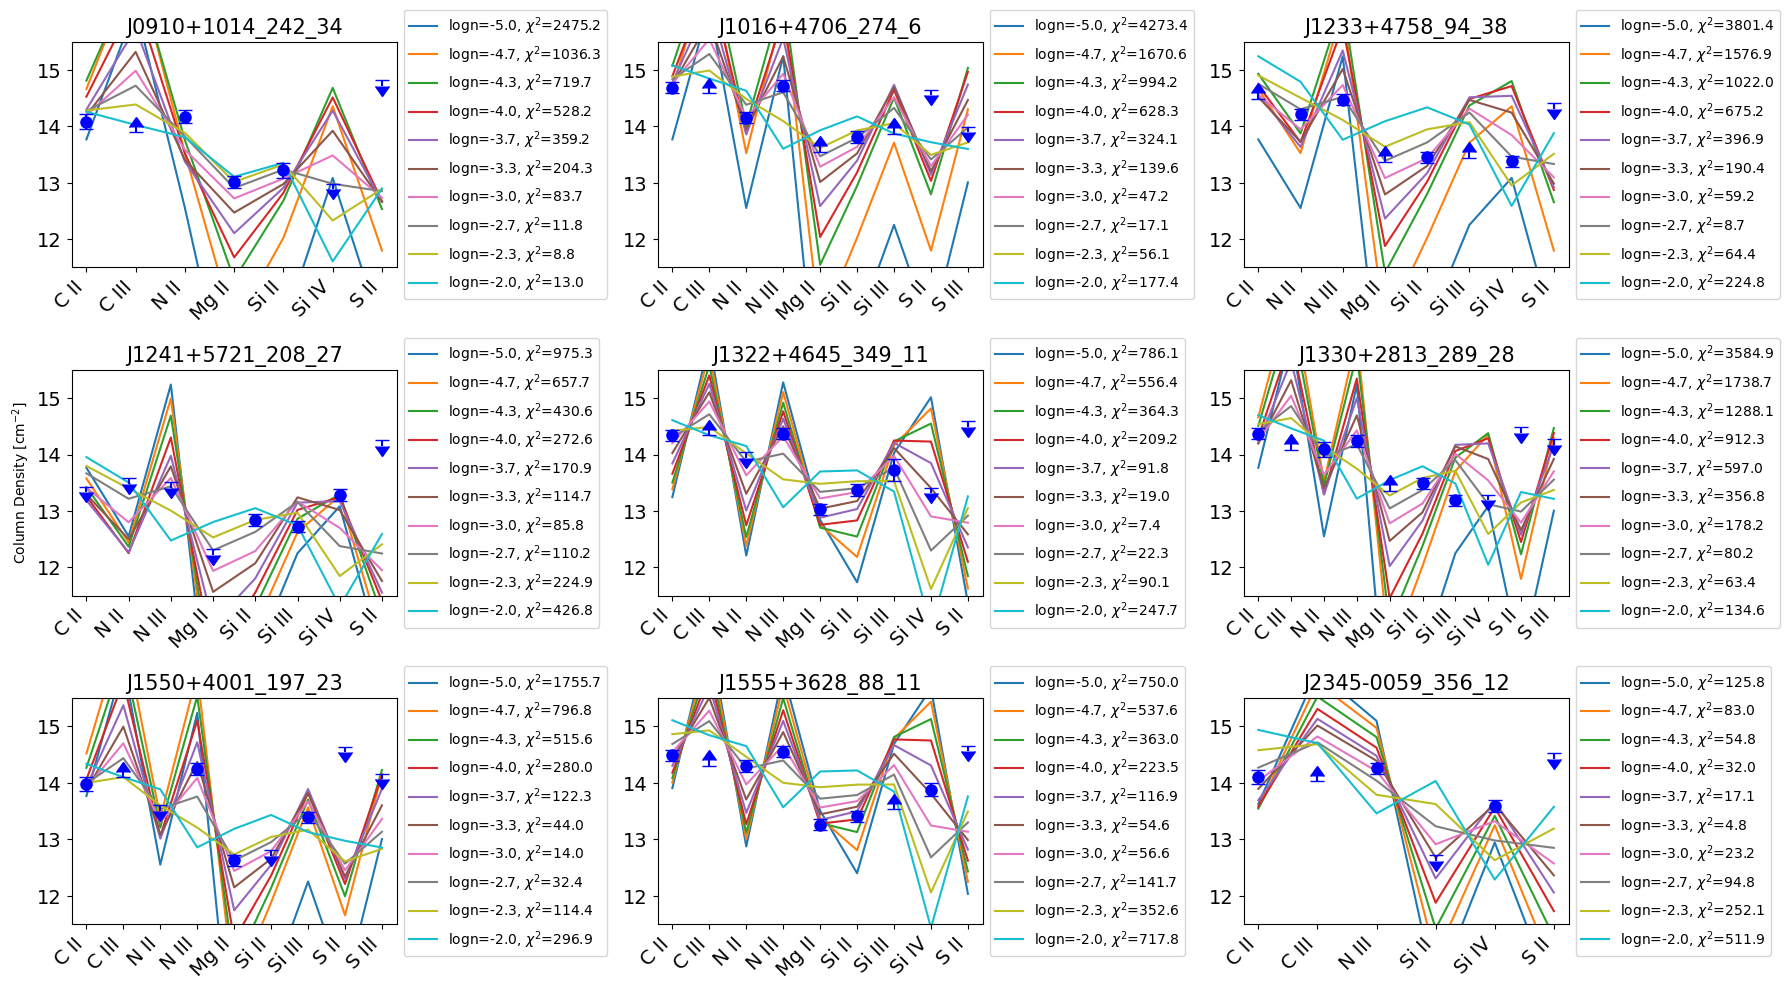

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import re


color_array = ['black', 'magenta', 'red',  'green', 'blue']


nrange = np.logical_and(narray> 1e-5, narray< 1e-1)

#generates the best fit model at each density (for noss and self shielding)
efrac_model_noss =  model_noss.sel(param=0, method ='nearest')
efrac_model_ss =  model.sel(param=0, method ='nearest')



# Function to extract the Roman numeral from ion names
def extract_roman_numeral(ion_name):
    match = re.search(r'\b[IVXLCDM]+\b', ion_name)
    if match:
        return match.group()
    return ""

fig, ax = plt.subplots(nrows=len(all_systems)//3, ncols=3, figsize=(18, 10))

for isys in range(len(all_systems)):
    ix = isys//3
    iy = isys%3
    
    if ss_flag[allwerksystems[isys]['H I'][-1]] == False:
        all_systems_plot = all_systems_noss
        efrac_model = efrac_model_noss
        [logNtotbestvec, chisqvec] = findSmallestChisqEachDensity(allwerksystems[isys],efrac_model, nrange)
        
    else:
        all_systems_plot = all_systems
        efrac_model = efrac_model_ss
        [logNtotbestvec, chisqvec] =  findSmallestChisqEachDensity(allwerksystems[isys],efrac_model, nrange)
    
    #print(isys, logNtotbestvec)
    
    # Sort data by Roman numeral
    [ion_names, logNmodel_values, logNobs_values, sigma_values, limit_values] = all_systems_plot[isys][1][0]


    for n in np.logspace(-5,-2, 10):
    
        columns=[]
        index_nearest = np.argmin(np.abs(np.array(narray[nrange==True]) - n))
        chisq =  chisqvec[index_nearest]
        for ion_name in ion_names:
            # Find the index of the minimum absolute difference
            #print(np.array(narray), n)

            columns.append(getModelLogIonicColumn(ion_name, logNtotbestvec[index_nearest], efrac_model.sel(n0=n,method='nearest')))
            
            
        ax[ix, iy].plot(np.arange(len(ion_names)), columns, label=f"logn={np.log10(n):.1f}, $\chi^2$={chisq:.1f}")
        
        

    for i, ion in enumerate(ion_names):
        x = i
        y = logNobs_values[i]
        sigma = sigma_values[i]
        if sigma < 0:
            if limit_values[i] == '>':
                ax[ix, iy].errorbar(x, y, yerr=min_sigma, marker='o', markersize=0, color='blue', capsize=5, lolims=True)
            if limit_values[i] == '<':
                ax[ix, iy].errorbar(x, y, yerr=min_sigma, marker='o', markersize=0, color='blue', capsize=5, uplims=True)
        else:
            ax[ix, iy].errorbar(x, y, yerr=sigma, marker='o', markersize=8, color='blue', capsize=5)

        

    
    # Set x-axis labels and tick positions
    ax[ix, iy].set_ylim(11.5, 15.5)
    ax[ix, iy].set_xticks(np.arange(len(ion_names)))
    ax[ix, iy].set_xticklabels(ion_names, rotation=45, ha='right')
    ax[ix, iy].tick_params(axis='both', labelsize=14)  
    
    system_name = allwerksystems[isys]['H I'][-1] #.replace('_', '\_')
    ax[ix,iy].set_title(system_name, fontsize=15)


    ax[ix, iy].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1, 0].set_ylabel('Column Density [cm$^{-2}$]')
# Show the plot
plt.tight_layout()
#plt.show()

plt.savefig(f'density_scan_{modelstring}.pdf')